In [1]:
from google.colab import files
uploaded = files.upload()

Saving Elon_musk.csv to Elon_musk.csv


In [2]:
import pandas as pd
df = pd.read_csv('Elon_musk.csv', encoding='latin1')

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Download necessary NLTK resources
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

#PreProcessing

In [5]:
df['Tweets'] = df['Text'].str.replace(r'@\w+', '')
tweets = [Text.strip() for Text in df.Tweets]

Text Cleaning

In [7]:
# Combining all the tweets into a single text
combined_text = ''.join(tweets)

In [8]:
import re
import string
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

cleaned_text = clean_text(combined_text)

In [9]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

cleaned_text = remove_emoji(cleaned_text)

# Preprocess text using NLTK

In [10]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from nltk.tokenize import word_tokenize
def preprocess_text(text):
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    return text

df['cleaned_text'] = df['Tweets'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Sentiment Analysis**

In [11]:
from textblob import TextBlob
def get_textblob_sentiment(cleaned_text):
    analysis = TextBlob(cleaned_text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

from nltk.sentiment.vader import SentimentIntensityAnalyzer
def get_vader_sentiment(cleaned_text):
    sid = SentimentIntensityAnalyzer()
    compound_score = sid.polarity_scores(cleaned_text)['compound']
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['textblob_sentiment'] = df['cleaned_text'].apply(get_textblob_sentiment)
df['vader_sentiment'] = df['cleaned_text'].apply(get_vader_sentiment)

Missing Values

In [12]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values_column = df['Text'].isnull().sum()

# Print missing values
print("Missing Values in the Entire Dataset:")
print(missing_values)

print("\nMissing Values in a Specific Column:")
print(missing_values_column)

Missing Values in the Entire Dataset:
Unnamed: 0            0
Text                  0
Tweets                0
cleaned_text          0
textblob_sentiment    0
vader_sentiment       0
dtype: int64

Missing Values in a Specific Column:
0


In [14]:
# Explore data distribution of sentiment labels
sentiment_distribution = df['vader_sentiment'].value_counts()

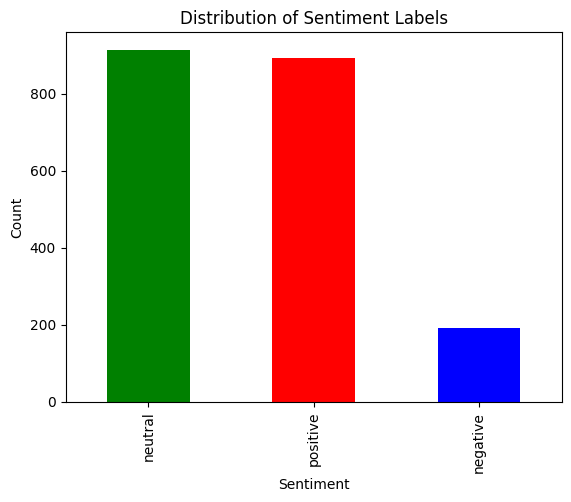

In [15]:
# Plotting the distribution
import matplotlib.pyplot as plt
sentiment_distribution.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

Spliting the data

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df['cleaned_text'], df['vader_sentiment'], test_size=0.2, random_state=42)

Vectorization

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

Traing the data

In [18]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train_tfidf, Y_train)
predictions = model.predict(X_test_tfidf)

In [19]:
# Evaluate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.755


**World Cloud**

In [20]:
from wordcloud import WordCloud
all_text = ' '.join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, random_state=42, max_font_size=100, background_color='white').generate(all_text)

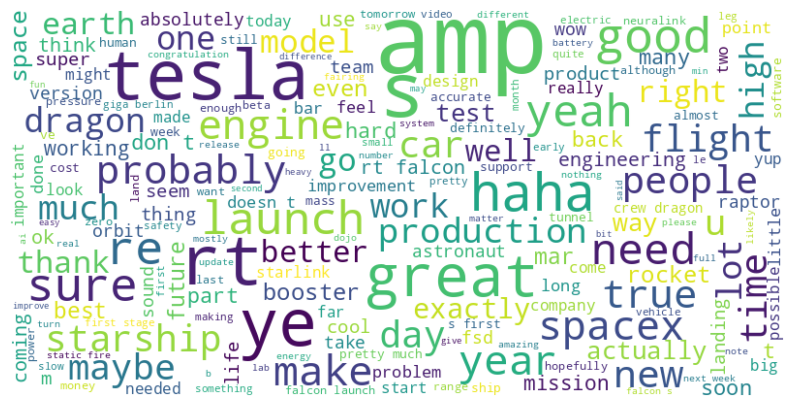

In [21]:
# Plot WordCloud image
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Checking Sentiment Analysis for New Text

In [22]:
new_text = "I really enjoyed the movie. It was fantastic!"
new_text_processed = preprocess_text(new_text)
new_text_vectorized = vectorizer.transform([new_text_processed])
prediction = model.predict(new_text_vectorized)[0]
print(f"Predicted Sentiment: {prediction}")

Predicted Sentiment: positive


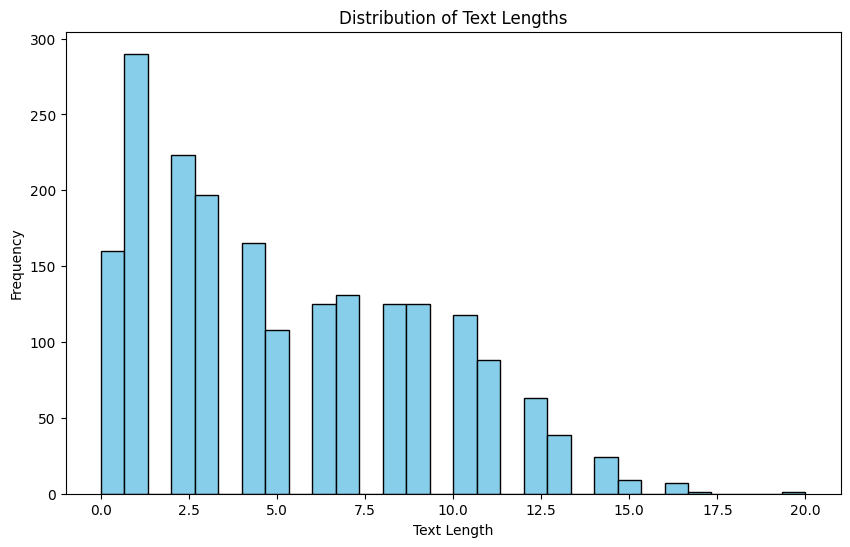

In [23]:
# Distribution of Text Lengths:
df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

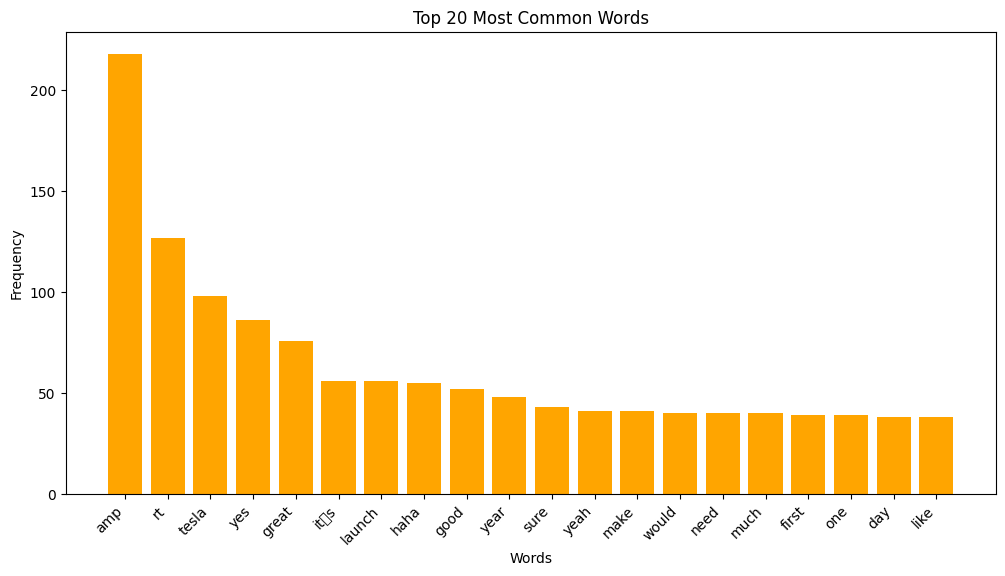

In [24]:
# Word Frequency Plot
from collections import Counter
words_counter = Counter(' '.join(df['cleaned_text']).split())
common_words = words_counter.most_common(20)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar([word[0] for word in common_words], [count[1] for count in common_words], color='orange')
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [25]:
# Sentiment Distribution Over Time:
sentiment_distribution = df['vader_sentiment'].value_counts()

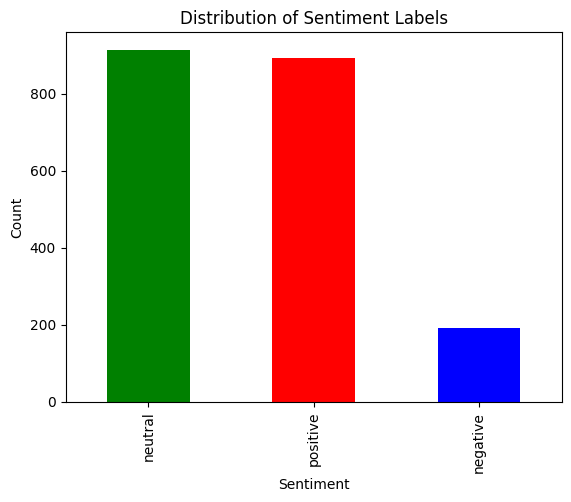

In [29]:
# Plotting the distribution
sentiment_distribution.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()